## TODO
1. Prepare corpus + decide on splits and experiment design
1. Add multiple word embeddings to model_builder and configs
1. Save test predictions to disk for every model
1. Run all configs (start with CRF ones)

## Prepare corpus

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [6]:
from conlleval import evaluate

In [39]:
from ner_utils import *

In [8]:
initialize_random_seeds()

In [9]:
df = (pd.read_csv('curation.csv.gz')
      .assign(sent=lambda x: x.file+'_'+x.sent.astype(str)))

In [10]:
df.head()

,sent_tok_num,tok_offset,token,FEAT_gender,FEAT_number,FEAT_case,FEAT_degree,FEAT_transitivity,FEAT_tense,FEAT_mood,...,dep_flavor,dep_lex_morph_pos,dep_arc,EXTRA,sent,ner_layers,ner_type,is_ner,biose,file
0,1-1,0-5,עשרות,Fem,Plur,*,*,*,*,*,...,basic,1-2,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
1,1-2,6-11,אנשים,Masc,Plur,*,*,*,*,*,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
2,1-3,12-18,מגיעים,Masc,Plur,*,*,*,*,*,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
3,1-4,19-20,מ,_,_,_,_,_,_,_,...,basic,1-5,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
4,1-5,21-27,תאילנד,_,_,_,_,_,_,_,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,1,GPE,True,S-GPE,dev_1-100.tsv


In [11]:
df.head().T

,0,1,2,3,4
sent_tok_num,1-1,1-2,1-3,1-4,1-5
tok_offset,0-5,6-11,12-18,19-20,21-27
token,עשרות,אנשים,מגיעים,מ,תאילנד
FEAT_gender,Fem,Masc,Masc,_,_
FEAT_number,Plur,Plur,Plur,_,_
FEAT_case,*,*,*,_,_
FEAT_degree,*,*,*,_,_
FEAT_transitivity,*,*,*,_,_
FEAT_tense,*,*,*,_,_
FEAT_mood,*,*,*,_,_


In [12]:
x=df
sents = x.groupby('sent')[['token', 'pos', 'biose']].apply(lambda x: x.values.tolist())
sents[:5]

sent
dev_1-100.tsv_1      [[עשרות, NUM, O], [אנשים, NOUN, O], [מגיעים, V...
dev_1-100.tsv_10     [[ישראל, PROPN, B-PER], [ארד, PROPN, E-PER], [...
dev_1-100.tsv_100    [[טום, PROPN, B-PER], [הארקין, PROPN, E-PER], ...
dev_1-100.tsv_11     [[ח"כ, NOUN, O], [אלי, PROPN, B-PER], [דיין, P...
dev_1-100.tsv_12     [[חברות, NOUN, O], [ה, SCONJ, O], [מעסיקות, VE...
dtype: object

In [13]:
words = list(set(x["token"].values))
n_words = len(words); n_words

17824

In [14]:
tags = list(set(x["biose"].values))
n_tags = len(tags); n_tags

37

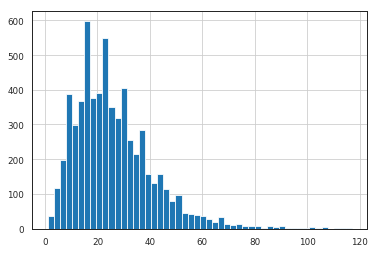

In [15]:
x.groupby('sent').size().hist(bins=50)

In [16]:
max_len=80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [17]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sents]

In [18]:
X = pad_sequences(maxlen=max_len, sequences=X, value=word2idx["PAD"], padding='post', truncating='post')

In [19]:
X[1]

array([ 3284, 14458,  6120,  1384,  4234,  1300,  4234,  2918,  6120,
        3759, 12609,  7821, 15987,  3613,  4234, 10141,  2503,  4234,
       11685,  6120,  6689, 12013,  6120, 11909,  4828, 14973, 16519,
         157,  6120,   449,  6289,  7212,  4534, 10764, 10468, 14078,
        4234, 13045, 14214, 16127,   162, 15950,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [20]:
pos = list(set(x["pos"].values))
n_pos = len(pos); n_pos

16

In [21]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0
X_pos = [[pos2idx[w[1]] for w in s] for s in sents]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos[0]

array([ 9, 12, 16, 15,  1, 15,  1,  2,  8, 16, 15, 12, 13, 14,  3, 16, 12,
       11, 11, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

## True tags

In [22]:
y = [[tag2idx[w[2]] for w in s] for s in sents]
y_numer = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [23]:
y_numer[1]

array([32, 27, 25, 25, 23, 10, 10, 28, 25, 25, 25, 25, 25, 25, 23, 10, 10,
       10, 28, 25, 32, 27, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [24]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y_numer]
y[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Perform train test splits

In [25]:
from sklearn.model_selection import train_test_split

splits = [train_test_split(X, y, X_pos, test_size=0.25, random_state=42+i) for i in range(3)]

### Prep char input

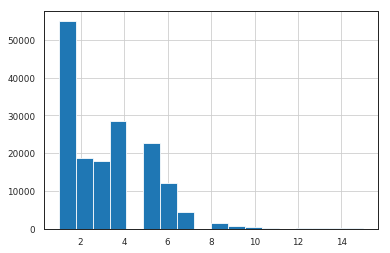

In [26]:
x.token.apply(len).hist(bins=18)

In [27]:
max_len_char = 10

In [28]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

49


In [29]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [30]:
X_char = []
for sentence in sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [31]:
splits_char = [train_test_split(X_char, y, test_size=0.25, random_state=42+i) for i in range(3)]

## Embeddings

In [32]:
!ls '../fasttext/'

src  wiki.he.vec


In [33]:
embedding_paths

{'yap_w2v_sg': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt',
 'yap_w2v_cbow': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_cbow.txt',
 'yap_glove': '../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt',
 'yap_ft_sg': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec',
 'yap_ft_cbow': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_cbow.model.vec',
 'token_w2v_sg': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_skipgram.txt',
 'token_w2v_cbow': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_cbow.txt',
 'token_glove': '../wordembedding-hebrew/glove/wikipedia.tokenized.glove.txt',
 'token_ft_sg': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_skipgram.model.vec',
 'token_ft_cbow': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_cbow.model.vec',
 'pretrained_token_ft': '../fasttext/wiki.he.vec'}

In [34]:
exclude = ['cbow']

In [35]:
embedding_mats = {}
for emb_name, emb_path in embedding_paths.items():
    skip=False
    for exc in exclude:
        if exc in emb_path:
            skip=True
    if skip:
        continue
    embedding_mats[emb_name] = get_embedding_matrix(emb_path, word2idx)

loading word embeddings: ../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 1358
sample words not found:  ['פאנטום' 'גנין' 'פשרנים' 'שלהם' 'מולנביק' 'שמעונוב' 'תאצר' 'מקסיקאיים'
 'וויטרזים' 'צרנר']
loading word embeddings: ../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 1358
sample words not found:  ['חלאסק' 'אקונומיק' 'התייפייפות' 'ספורטיווית' 'אוגרסהיים' 'בערנות'
 'לוונטינים' 'החשדה' 'סאותהמפטון' 'גנאק']
loading word embeddings: ../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 1358
sample words not found:  ['נאסיונאל' '01.4' '0891' 'ריינאלדו' '8891' 'נאיווית' 'ווצרנאיה' 'התרשמנו'
 'הואילו' 'וויטאק']
loading word embeddings: ../wordembedding-hebrew/wikipedia.tokenized.word2ve

## Model building

In [40]:
configs = build_configs(base_configs, embedding_mats)
configs     

[{'crf': True, 'use_pos': False},
 {'crf': True, 'use_pos': True},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_w2v_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_glove',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_w2v_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_glove',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_

In [41]:
out_folder = 'outputs3'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

Train on 4195 samples, validate on 467 samples
Epoch 1/100
 - 51s - loss: 0.3631 - crf_accuracy: 0.9257 - val_loss: 0.1608 - val_crf_accuracy: 0.9717
Epoch 2/100
 - 46s - loss: 0.1380 - crf_accuracy: 0.9702 - val_loss: 0.1190 - val_crf_accuracy: 0.9729
Epoch 3/100
 - 48s - loss: 0.0997 - crf_accuracy: 0.9738 - val_loss: 0.0953 - val_crf_accuracy: 0.9761
Epoch 4/100
 - 44s - loss: 0.0713 - crf_accuracy: 0.9782 - val_loss: 0.0800 - val_crf_accuracy: 0.9784
Epoch 5/100
 - 45s - loss: 0.0511 - crf_accuracy: 0.9830 - val_loss: 0.0971 - val_crf_accuracy: 0.9675
Epoch 6/100
 - 50s - loss: 0.0373 - crf_accuracy: 0.9857 - val_loss: 0.0560 - val_crf_accuracy: 0.9818
Epoch 7/100
 - 46s - loss: 0.0272 - crf_accuracy: 0.9878 - val_loss: 0.0500 - val_crf_accuracy: 0.9831
Epoch 8/100
 - 46s - loss: 0.0191 - crf_accuracy: 0.9895 - val_loss: 0.0500 - val_crf_accuracy: 0.9811
Epoch 9/100
 - 44s - loss: 0.0121 - crf_accuracy: 0.9911 - val_loss: 0.0502 - val_crf_accuracy: 0.9829
Epoch 10/100
 - 44s - loss

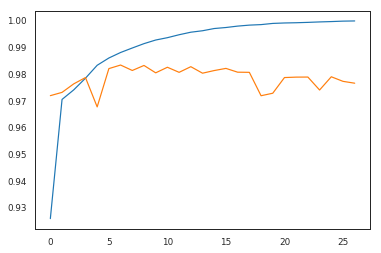

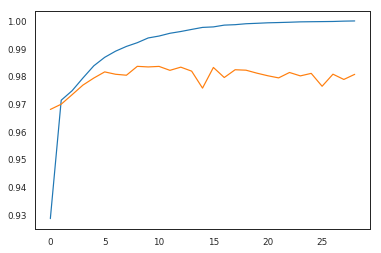

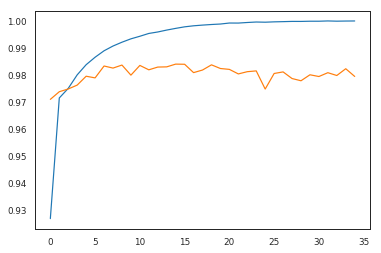

processed 39438 tokens with 1894 phrases; found: 1602 phrases; correct: 1009.
accuracy:  50.82%; (non-O)
accuracy:  94.69%; precision:  62.98%; recall:  53.27%; FB1:  57.72
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  73.61%; recall:  73.27%; FB1:  73.44  432
              LOC: precision:  25.00%; recall:  22.62%; FB1:  23.75  76
              ORG: precision:  50.19%; recall:  46.43%; FB1:  48.24  532
              PER: precision:  72.06%; recall:  59.82%; FB1:  65.38  562
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
processed 40573 tokens with 1907 phrases; found: 1633 phrases; correct: 1066.
accuracy:  55.06%; (non-O)
accuracy:  95.02%; precision:  65.28%; recall:  55.90%; FB1:  60.23
        

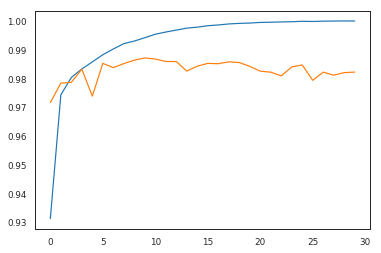

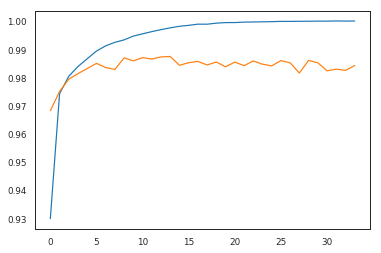

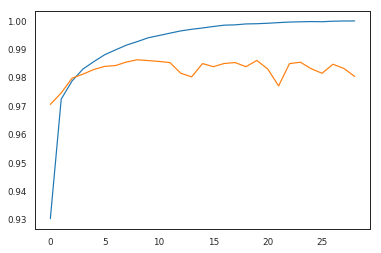

processed 39438 tokens with 1894 phrases; found: 1826 phrases; correct: 1365.
accuracy:  67.23%; (non-O)
accuracy:  96.41%; precision:  74.75%; recall:  72.07%; FB1:  73.39
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:  40.00%; recall:  11.32%; FB1:  17.65  15
              GPE: precision:  82.46%; recall:  80.18%; FB1:  81.31  422
              LOC: precision:  46.81%; recall:  52.38%; FB1:  49.44  94
              ORG: precision:  68.30%; recall:  65.57%; FB1:  66.90  552
              PER: precision:  79.41%; recall:  87.15%; FB1:  83.10  743
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
processed 40573 tokens with 1907 phrases; found: 1830 phrases; correct: 1363.
accuracy:  67.44%; (non-O)
accuracy:  96.33%; precision:  74.48%; recall:  71.47%; FB1:  72.95
       

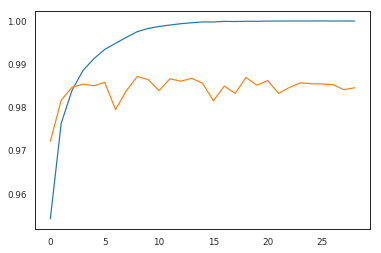

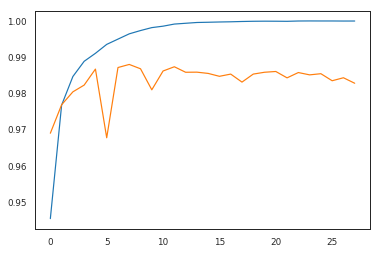

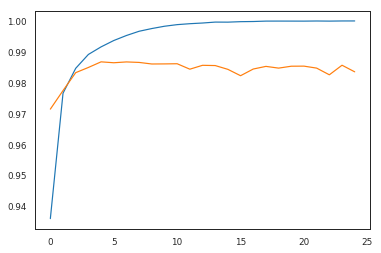

processed 39438 tokens with 1894 phrases; found: 2080 phrases; correct: 1434.
accuracy:  71.57%; (non-O)
accuracy:  96.02%; precision:  68.94%; recall:  75.71%; FB1:  72.17
              ANG: precision:  50.00%; recall:  22.22%; FB1:  30.77  4
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              FAC: precision:  80.00%; recall:  15.09%; FB1:  25.40  10
              GPE: precision:  86.18%; recall:  84.79%; FB1:  85.48  427
              LOC: precision:  63.24%; recall:  51.19%; FB1:  56.58  68
              ORG: precision:  58.46%; recall:  73.91%; FB1:  65.28  727
              PER: precision:  70.51%; recall:  85.82%; FB1:  77.42  824
              WOA: precision:  36.84%; recall:  25.00%; FB1:  29.79  19
processed 40573 tokens with 1907 phrases; found: 1836 phrases; correct: 1368.
accuracy:  68.60%; (non-O)
accuracy:  96.37%; precision:  74.51%; recall:  71.74%; FB1:  73.10
      

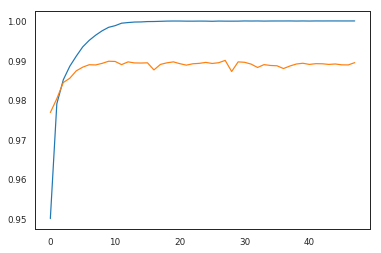

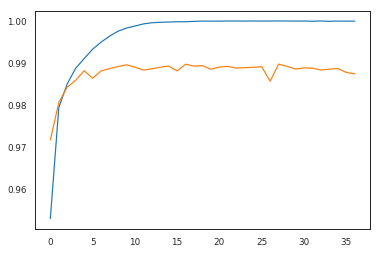

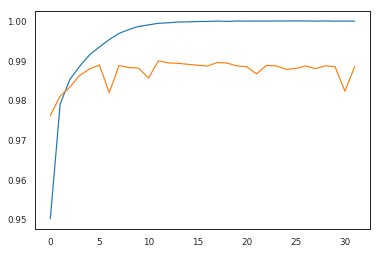

processed 39438 tokens with 1894 phrases; found: 1989 phrases; correct: 1504.
accuracy:  76.66%; (non-O)
accuracy:  96.79%; precision:  75.62%; recall:  79.41%; FB1:  77.47
              ANG: precision:  83.33%; recall:  55.56%; FB1:  66.67  6
              DUC: precision:  44.44%; recall:  40.00%; FB1:  42.11  9
              EVE: precision:  52.63%; recall:  41.67%; FB1:  46.51  19
              FAC: precision:  39.02%; recall:  30.19%; FB1:  34.04  41
              GPE: precision:  87.13%; recall:  88.94%; FB1:  88.03  443
              LOC: precision:  64.00%; recall:  76.19%; FB1:  69.57  100
              ORG: precision:  66.97%; recall:  76.87%; FB1:  71.58  660
              PER: precision:  83.95%; recall:  83.46%; FB1:  83.70  673
              WOA: precision:  31.58%; recall:  42.86%; FB1:  36.36  38
processed 40573 tokens with 1907 phrases; found: 2057 phrases; correct: 1486.
accuracy:  75.82%; (non-O)
accuracy:  96.65%; precision:  72.24%; recall:  77.92%; FB1:  74.97
    

In [ ]:
configs, results, preds, histories = run_models(configs, splits, splits_char, embedding_mats, 
                                                words, max_len, n_words, idx2word, idx2tag,
                                                n_tags, max_len_char, n_pos, n_chars,
                                                run_name='treebank_gold', out_folder=out_folder,
                                                skip_if_model_exists=True)

In [ ]:
results

In [46]:
for c in configs:
    if 'embedding_matrix' in c:
        c.update({'embedding_matrix': 'fastext'}) 

In [47]:
defaults = {'use_word': True, 'use_pos': False, 'embedding_matrix': None, 
            'embed_dim': 70, 'trainable': True, 'input_dropout': False, 
            'stack_lstm': 1, 'epochs': 100, 'early_stopping': True, 'patience': 20, 
            'min_delta': 0.0001, 'use_char': False, 'crf': False, 'stack_cross': False, 
            'stack_double': False, 'rec_dropout': 0.1}

In [48]:
for conf in configs:
    conf.update({'use_morpheme': True})
    conf.update({'use_word': False})

    for key in defaults:
        if key not in conf:
            conf[key] = defaults[key]

In [ ]:
len(list(zip(configs, results, preds, histories)))

In [52]:
def get_results_df(configs, results):
    dict_res = []
    for conf, res in zip(configs, results):
        dr = {}
        for i, r in enumerate(res):
            split_name = chr(ord('a')+i)
            dr['prec_'+split_name], dr['recall_'+split_name], dr['f1_'+split_name] = r
        dr.update(conf)
        dict_res.append(dr)
    rdf = (pd.DataFrame(dict_res)
           .assign(prec = lambda x: (x.prec_a + x.prec_b + x.prec_c)/3)
           .assign(recall = lambda x: (x.recall_a + x.recall_b + x.recall_c)/3)
           .assign(f1 = lambda x: (x.f1_a + x.f1_b + x.f1_c)/3))
    return rdf

In [53]:
res1 = pickle.load(open('treebank_results_1.pkl', 'rb'))

In [54]:
res2 = pickle.load(open('treebank_results_2_test25.pkl', 'rb'))

In [57]:
rdf1 = get_results_df([c for c, r, h in res1], [r for c, r, h in res1])

In [58]:
rdf2 = get_results_df([c for c, r, p, h in res2], [r for c, r, p, h in res2])

In [60]:
rdf2.head()

,crf,early_stopping,embed_dim,embedding_matrix,epochs,f1_a,f1_b,f1_c,input_dropout,min_delta,...,stack_double,stack_lstm,trainable,use_char,use_morpheme,use_pos,use_word,prec,recall,f1
0,True,True,70,None,100,61.595231,64.524986,63.937419,False,0.0001,...,False,1,True,False,True,False,False,66.866298,60.221498,63.352545
1,True,True,70,None,100,72.074967,71.615721,72.101911,False,0.0001,...,False,1,True,False,True,True,False,73.574440,70.383441,71.930866
2,True,True,300,fastext,100,77.924131,76.407437,77.421053,False,0.0001,...,False,1,True,False,True,False,False,78.371539,76.234033,77.250873
3,True,True,300,fastext,100,80.941052,79.862215,80.050761,False,0.0001,...,False,1,True,False,True,True,False,80.810288,79.768234,80.284676
4,True,True,70,None,100,69.732492,67.697498,70.299037,False,0.0001,...,False,1,True,True,True,False,False,74.882658,64.751970,69.243009


In [61]:
 (rdf2.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                63.4  71.9  69.2  75.0
fastext           77.3  80.3  82.0  83.3

In [63]:
 (rdf1.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                67.9  74.4  70.7  75.8
fastext           79.4  83.4  82.9  84.6